# Obtaining Pitch angles for a galaxy

This notebook will go from raw classification count, through the spiral arm extraction process, to galaxy deprojection and finally obtain plots for pitch angles of a galaxy.

It has been parametrised using [papermill](https://github.com/nteract/papermill).

Set up our environment:

In [116]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

print('Finished magic commands')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Finished magic commands


In [124]:
print('Importing required modules...')
import pandas
import requests
import pandas as pd
import numpy as np
import json
import os
from shapely.geometry import LineString
from tempfile import NamedTemporaryFile
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import spiralExtraction
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

print('Finished Imports')

Importing required modules...
Finished Imports


Open the NASA Sloan Atlas for galaxy metadata

In [3]:
nsa = fits.open('../../subjectUpload/nsa_v1_0_1.fits')

Open the classifications and subjects. Filter for the most recent workflow and select galaxies with more than 25 classifications

In [4]:
classifications = pandas.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pandas.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

most_recent_workflow = classifications.workflow_version == 61.107
classifications[most_recent_workflow].groupby('subject_ids')
classificationsCounts = classifications[most_recent_workflow]['subject_ids'].value_counts()
subjIds = np.array(classificationsCounts[classificationsCounts > 25].index)

print('Identified {} subjects with more than 25 classifications'.format(spiralExtraction.purple(subjIds.shape[0])))

Identified 56 subjects with more than 25 classifications


Define some helper functions

In [5]:
deNormArm = lambda a: 512*(0.5 + a)
getUrl = lambda id: eval(subjects[subjects['subject_id'] == id]['locations'].iloc[0])['1']

def getDrawnArms(id):
    annotationsForSubject = [
        eval(foo) for foo in 
        classifications[classifications['subject_ids'] == id]['annotations']
    ]
    try:
        annotationsWithSpiral = [
            c[3]['value'][0]['value']
            for c in annotationsForSubject
            if len(c) > 3 and len(c[3]['value'][0]['value'])
        ]
    except IndexError as e:
        print('{} raised {}'.format(id, e))
        assert False
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([
        np.array(arm) for classification in spiralsWithLengthCut
        for arm in classification
        if LineString(arm).is_simple
    ])
    return drawnArms

def p(line, *args, ax=plt, **kwargs):
    ax.plot(line[:, 0], line[:, 1], *args, **kwargs)

Define the Zooniverse subject ID of the galaxy we wish to work on (parametrised using papermill).

In [120]:
chosenId = 21096919

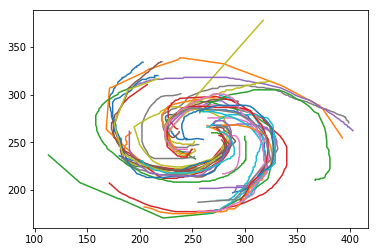

In [121]:
drawnArms = getDrawnArms(chosenId)
for arm in drawnArms:
    p(arm)

Let's download the image that was shown to volunteers. We'll need it to recreate the transform from classification coordinates to world coordinates (because I didn't document the original process properly).

In [126]:
url = getUrl(chosenId)
print('URL of galaxy image:')
print(url)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

URL of galaxy image:
https://panoptes-uploads.zooniverse.org/production/subject_location/35c0d429-f6c2-4f3b-b005-fa713999b843.png


Next, we'll run the spiral arm extraction pipeline!

In [8]:
res = spiralExtraction.fit(drawnArms, verbose=True, fullOutput=True)
functions = res['functions']
labels = res['labels']

Calculating distance matrix (this can be slow)
Clustering arms
Working on arm label 0
	[1 / 4] Cleaning points (1083 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
Working on arm label 1
	[1 / 4] Cleaning points (1053 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
done!


Grab the Zooniverse metadata associated with this subject:

In [123]:
meta = eval(subjects[subjects['subject_id'] == chosenId].iloc[0]['metadata'])
meta

{'#isModelling': True,
 '#models': [{'frame': 0, 'model': 'GALAXY_BUILDER_DIFFERENCE'},
  {'frame': 2, 'model': 'GALAXY_BUILDER_MODEL'}],
 'Camcol': '5',
 'Common name': 'Unknown',
 'Estimated distance': '0.022105522453784943 * c / H_0',
 'Field': '230',
 'NSA id': '183513',
 'Petrosian radius (degrees)': '20.187799',
 'Rerun': '301',
 'Run': '2964',
 'SDSS dr7 id': '587732484354342925',
 'Sersic axis ratio': '0.626135',
 'Url to view': '[skyserver link](+tab+http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=163.80894470214844&dec=48.724327087402344&opt=F)',
 'dec': '48.724327',
 'ra': '163.808945',
 'redshift': '0.021919'}

And the NSA data for this galaxy, using the NSA id in the Zooniverse metadata.

In [125]:
nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA', 
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)
print('Made NSA data frame')

Made NSA data frame


In [11]:
gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
gal

,CAMCOL,DEC,FIELD,IAUNAME,INED,ISDSS,NSAID,PETRO_THETA,RA,RERUN,RUN,SERSIC_BA,SERSIC_PHI,Z,ZDIST
173652,5,48.724332,230,J105514.14+484327.5,92090,187976,183513,20.187799,163.809007,301,2964,0.626135,68.628601,0.021919,0.022106


Grab the name of the FITS file containing the galaxy

In [12]:
# Lookup the source fits file (needed for the rotation matrix)
fname = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
    int(gal['RUN']),
    int(gal['CAMCOL']),
    int(gal['FIELD'])
)
print('Source fits file:', fname)

Source fits file: fitsImages/2964/5/frame-r-002964-5-0230.fits


Grab a WCS object from the fits file, and then use it to engineer a WCS object for the galaxy image (needed as we interpolated the image up to 512x512 pixels)

In [13]:
# Load a WCS object from the FITS image
wFits = WCS(fname)
print('\n\nWCS from fits image:', wFits)

# The SDSS pixel scale is 0.396 arc-seconds
fits_cdelt = 0.396 / 3600

phi = float(gal['SERSIC_PHI'])

# cutouts were chosen to be 4x Petrosean radius, and then scaled (including interpolation) to be 512x512 pixels
scale = 4 * (float(gal['PETRO_THETA']) / 3600) / 512

# This should be obtained from the image, as some were not square.
size_pix = np.array([512, 512])

# Create a new WCS object
w = WCS(naxis=2)
w.wcs.crpix = size_pix / 2
w.wcs.crval = np.array([float(gal['RA']), float(gal['DEC'])])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
w.wcs.cunit = ['deg', 'deg']

# Copy the rotation matrix from the source FITS file, adjusting the scaling as needed
w.wcs.cd = [
    wFits.wcs.cd[0] / fits_cdelt * scale,
    wFits.wcs.cd[1] / fits_cdelt * scale
]

print('\n\nCreated WCS:')
print(w)



WCS from fits image: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 163.877359527  48.793323674  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : -3.03327270869e-05  0.000105729444133  
CD2_1 CD2_2  : 0.00010575477997  3.03731913662e-05  
NAXIS : 2048  1489


Created WCS:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 163.80900681326085  48.724332362415986  
CRPIX : 256.0  256.0  
CD1_1 CD1_2  : -1.208078857550551e-05  4.210946998326861e-05  
CD2_1 CD2_2  : 4.211956063187082e-05  1.209690451528511e-05  
NAXIS : 0  0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Now calculate the rotations from world coordinates of the NSA Sersic parameters to pixel coordinates (specifically the rotation).

[0.93123784 0.36441197]


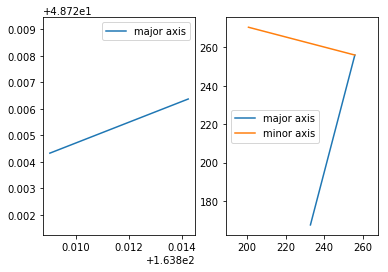

In [14]:
r = float(gal['PETRO_THETA'])/3600

cx, cy = 256, 256
wCx, wCy = float(gal['RA']), float(gal['DEC'])

# find our line in world coordinates
x = r * np.sin(np.deg2rad(phi)) + wCx
y = r * np.cos(np.deg2rad(-phi)) + wCy

v = np.array([x - wCx, y - wCy])
v /= np.linalg.norm(v)

print(v)

ra_line, dec_line = w.wcs_world2pix([wCx, x], [wCy, y], 0)

axis_vector = np.subtract.reduce(
    np.stack(
        (ra_line, dec_line),
        axis=1
    )
)

normal_vector = np.dot([[0, 1], [-1, 0]], axis_vector) * float(gal['SERSIC_BA']) 
origin = np.array([cx, cy])

plt.subplot(121)
plt.axis('equal')
plt.plot([wCx, x], [wCy, y], label='major axis')
plt.legend()
plt.subplot(122)
plt.axis('equal')
plt.plot(*np.stack((origin, origin + axis_vector), axis=1), label='major axis')
plt.plot(*np.stack((origin, origin + normal_vector), axis=1), label='minor axis')
plt.legend()


In [35]:
angle = 180 * np.arccos(axis_vector[1]/np.linalg.norm(axis_vector))/ np.pi

165.34941614262883


Recreate the cutout shown to volunteer (non-trivial due to poor decision making at the cutout stage).

In [27]:
fitsFile = fits.open(fname)
imageData = scg.cutFits(
    fitsFile,
    float(gal['RA']), float(gal['DEC']),
    size=(4 * r * u.degree, 4 * r * u.degree)
)

objects, segmentation_map = csf.sourceExtractImage(
    imageData,
    fitsFile[2].data[0][0]
)

# create a true/false masking array
mask = csf.maskArr(imageData, segmentation_map, objects[-1][0] + 1)

# create the masked image
maskedImageData = imageData[:]
maskedImageData[mask] = 0

# apply an asinh stretch
stretchedImageData = csf.stretchArray(maskedImageData[:, ::-1])

resizeTo = (512, 512)

im = csf.saveImage(
    stretchedImageData,
    fname='./sparcfireTest.png',
    resize=True,
    size=resizeTo
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


https://panoptes-uploads.zooniverse.org/production/subject_location/35c0d429-f6c2-4f3b-b005-fa713999b843.png


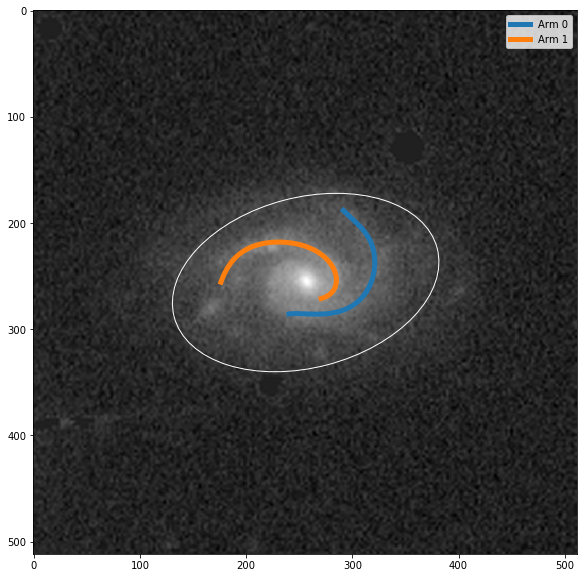

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(np.array(pic), cmap='gray')

t = np.linspace(0, 1, 500)
for i, (Sx, Sy) in enumerate(functions):
    plt.plot(deNormArm(Sx(t)), deNormArm(Sy(t)), linewidth=5, label='Arm {}'.format(i))
    
e = Ellipse(
    xy=(256, 256),
    width=256 * gal['SERSIC_BA'],
    height=256,
    angle=90 + angle,
    ec='w',
    fc='none'
)
# plt.plot(*np.stack((origin, origin + axis_vector), axis=1), label='major axis')
# plt.plot(*np.stack((origin, origin + normal_vector), axis=1), label='minor axis')
ax.add_artist(e)
plt.legend()

Sorting extracted objects by radius from center
📷  Saving image to ./sparcfireTest.png


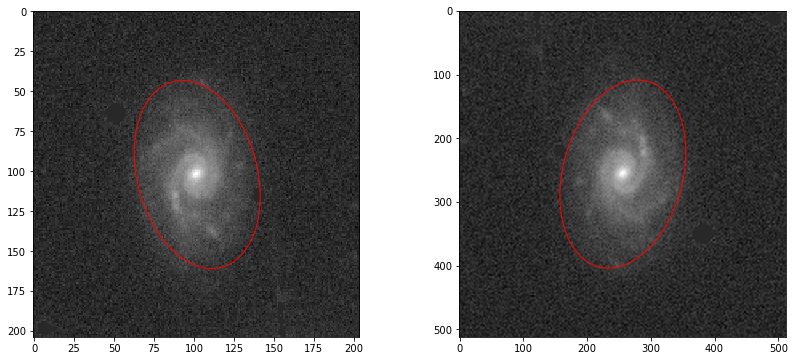

In [75]:
objects, segmentation_map = csf.sourceExtractImage(
    imageData,
    fitsFile[2].data[0][0]
)

# create a true/false masking array
mask = csf.maskArr(imageData, segmentation_map, objects[-1][0] + 1)

# create the masked image
maskedImageData = imageData[:]
maskedImageData[mask] = 0

# apply an asinh stretch
stretchedImageData = csf.stretchArray(maskedImageData[:, ::-1])

resizeTo = (512, 512)

im = csf.saveImage(
    stretchedImageData,
    fname='./sparcfireTest.png',
    resize=True,
    size=resizeTo
)

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(stretchedImageData, cmap='gray')
e = Ellipse(
    xy=(imageData.shape[0]/2, imageData.shape[1]/2),
    width=120 * gal['SERSIC_BA'],
    height=120,
    angle=angle,
    ec='r',
    fc='none'
)
ax = plt.gca()
ax.add_artist(e)

plt.subplot(122)
plt.imshow(np.array(im), cmap='gray')
e = Ellipse(
    xy=(np.array(im).shape[0]/2, np.array(im).shape[1]/2),
    width=np.array(im).shape[0] / imageData.shape[0] * 120 * gal['SERSIC_BA'],
    height=np.array(im).shape[1] / imageData.shape[1] * 120,
    angle=-angle,
    ec='r',
    fc='none'
)
ax = plt.gca()
ax.add_artist(e)


In [96]:
from scipy.ndimage.filters import gaussian_filter

[2631994.4652589764, 2153501.898128731, 2042663.5833284725]


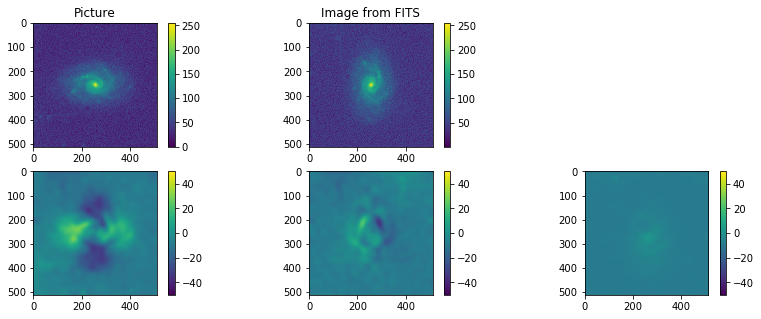

In [128]:


plt.figure(figsize=(14,5))
a1 = np.array(pic)
plt.subplot(231)
plt.title('Picture')
plt.imshow(a1)
plt.colorbar()

plt.subplot(232)
plt.title('Image from FITS')
plt.imshow(np.array(im))
plt.colorbar()

picArray = np.array(pic).astype(float)
imArray = np.array(im).astype(float)
d1 = gaussian_filter(picArray - imArray, 10)
d2 = gaussian_filter(picArray.T - imArray, 10)
d3 = gaussian_filter(picArray.T[:, ::-1] - imArray, 10)

nPix = picArray.shape[0] * picArray.shape[1]
print(list(map(np.sum, map(np.abs, (d1, d2, d3)))))

plt.subplot(234)
plt.imshow(d1, vmin=-50, vmax=50)
plt.colorbar()

plt.subplot(235)
plt.imshow(d2, vmin=-50, vmax=50)
plt.colorbar()

plt.subplot(236)
plt.imshow(d3, vmin=-50, vmax=50)
plt.colorbar()

Angle calclated to be 0.32175055439664213 radians


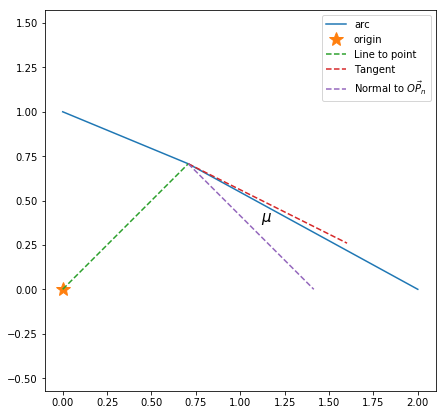

In [20]:
O = np.array((0, 0))
pnm1 = np.array((0, 1))
pn = np.array((1/np.sqrt(2), 1/np.sqrt(2)))
pnp1 = np.array((2, 0))

pnUnitVec = pn / np.linalg.norm(pn)

originLine = np.stack((O, pn), axis=1)

unitTangent = (pnp1 - pnm1) / np.linalg.norm(pnp1 - pnm1)

tangentLine = np.stack((pn, pn+unitTangent), axis=1)

# rotate pn vector by pi/2 (anticlockwise?)
normal = np.dot([[0, 1], [-1, 0]], pn)

# ensure it's a unit vector
normal /= np.linalg.norm(normal)
normalLine = np.stack((pn, pn+normal), axis=1)

plt.figure(figsize=(7, 7))
ax = plt.gca()

plt.axis('equal')
plt.plot([pnm1[0], pn[0], pnp1[0]], [pnm1[1], pn[1], pnp1[1]], label='arc')
plt.plot(O[0], O[1], '*', label='origin', markersize=15)
plt.plot(*originLine, '--', label='Line to point')
plt.plot(*tangentLine, '--', label='Tangent')
plt.plot(*normalLine, '--', label=r'Normal to $\vec{OP_n}$')

bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
theta = ax.text(1.15, 0.4, "$\mu$", ha="center", va="center", rotation=0, size=15)
plt.legend()


print('Angle calclated to be {} radians'.format(np.pi/2 - np.arccos(np.dot(pnUnitVec, unitTangent))))


In [21]:
def deprojectArm(phi, ba, arm):
    p = np.deg2rad(phi)
    Xs = ba * (np.cos(p)*arm[:, 0] - np.sin(p)*arm[:, 1])
    Ys = 1 * (np.sin(p)*arm[:, 0] + np.cos(p)*arm[:, 1])
    
    x2 = np.cos(-p) * Xs - np.sin(-p) * Ys
    y2 = np.sin(-p) * Xs + np.cos(-p) * Ys
    return np.stack((x2, y2), axis=1)

In [22]:
Sx, Sy = functions[0]
t = np.linspace(0, 1, 500)
arm = np.stack((Sx(t), Sy(t)), axis=1)
deprojectedArm = deprojectArm(angle, float(gal['SERSIC_BA']), arm)
pas = np.zeros(deprojectedArm.shape[0]-2)
O = np.array([0, 0])
for i in range(1, deprojectedArm.shape[0] - 1):
    pnm1 = deprojectedArm[i-1]
    pn = deprojectedArm[i]
    pnp1 = deprojectedArm[i + 1]
    unitTangent = (pnp1 - pnm1) / np.linalg.norm(pnp1 - pnm1)
    
    pas[i - 1] = np.pi/2 - np.arccos(np.dot(pn / np.linalg.norm(pn), unitTangent))

In [23]:
getRadius = lambda c: np.sqrt(np.add.reduce(c**2, axis=1))

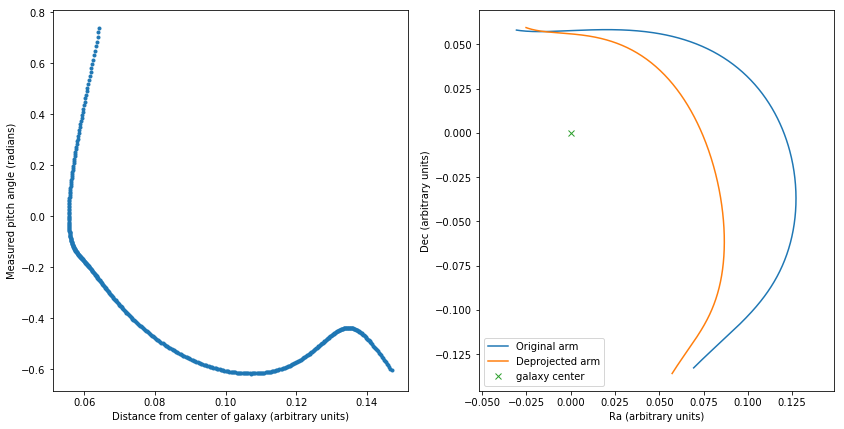

In [24]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(getRadius(deprojectedArm[1: -1]), pas, '.')
plt.xlabel('Distance from center of galaxy (arbitrary units)')
plt.ylabel('Measured pitch angle (radians)')
plt.subplot(122)
plt.axis('equal')
p(arm, label='Original arm')
p(deprojectedArm, label='Deprojected arm')
plt.plot(0, 0, 'x', label='galaxy center')
plt.xlabel('Ra (arbitrary units)')
plt.ylabel('Dec (arbitrary units)')
plt.legend()